Loading libraries:

In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from scipy.stats import norm
from sklearn.decomposition import PCA # Основной класс, который нам нужен
from sklearn.preprocessing import StandardScaler # Стандартизация, обязательно воспользуйтесь именно этим классом
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
warnings.filterwarnings("ignore")
np.random.seed(42)

## Loading data

Downloading data about superconductors:

In [3]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip

## Unzipping the data:

In [4]:
# !unzip superconduct.zip

## Combining both files into one table:

In [5]:
t1 = pd.read_csv("unique_m.csv")
t2 = pd.read_csv("train.csv")
df = pd.concat([t1.loc[:, t1.columns != 'material'], t2.loc[:, t2.columns != 'material']], axis=1)

## Creating training and test data:

Possibility 1:

In [6]:
# training_data = df.sample(frac=0.8)
# testing_data = df.drop(training_data.index)

Possibility 2 with sklearn:

In [7]:
from sklearn.model_selection import train_test_split

# training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

X = df.loc[:, df.columns != "critical_temp"]
y = df.loc[:, "critical_temp"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## Standardizing data except for the target variable "critical_temp":

In [8]:
# training_features = training_data.loc[:, training_data.columns != "critical_temp"]
# training_critical_temp = training_data.loc[:, "critical_temp"]

# normalizer = StandardScaler().fit(training_features)
# training_standardized_features = normalizer.transform(training_features)

# test_features = testing_data.loc[:, testing_data.columns != "critical_temp"]
# test_critical_temp = testing_data.loc[:, "critical_temp"]
# test_standardized_features = normalizer.transform(test_features)

standardizer = StandardScaler().fit(X_train)
stX_train = standardizer.transform(X_train)
stX_test = standardizer.transform(X_test)

## Building linear model:

Calculating some of the possible statistics [source](https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/):

In [9]:
import sklearn.metrics as metrics
def lr_statistics(y, y_pred, stX):
    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(rmse)
    r2 = metrics.r2_score(y, y_pred)
    n = stX.shape[0]
    p = stX.shape[1]
    adj_r2_score = 1 - (1-r2)*(n-1)/(n-p-1)
    return [mae, mse, rmse, rmsle, r2, adj_r2_score]

In [10]:
# model = LinearRegression().fit(training_standardized_features, training_critical_temp)

# training_r_sq = model.score(training_standardized_features, training_critical_temp)

# test_r_sq = model.score(test_standardized_features, test_critical_temp)

# n_training = training_standardized_features.shape[0]
# p_training = training_standardized_features.shape[1]
# training_r_adj_sq = 1 - (1 - training_r_sq) * (n_training - 1)/ (n_training - p_training - 1)
# n_test = test_standardized_features.shape[0]
# p_test = test_standardized_features.shape[1]
# test_r_adj_sq = 1 - (1 - test_r_sq)  * (n_test - 1)/ (n_test - p_test - 1)
# lm_statistics = {
#     "R$^2$ for training data": training_r_sq,
#     "Adjusted R$^2$ for training data": training_r_adj_sq,
#     "R$^2$ for test data": test_r_sq,
#     "Adjusted R$^2$ for test data": test_r_adj_sq    
# }
# pd.DataFrame(lm_statistics, index = ["Linear model statistics"])

lr_model = LinearRegression().fit(stX_train, y_train)
y_pred_train = lr_model.predict(stX_train)
y_pred_test = lr_model.predict(stX_test)

statistics_train = lr_statistics(y_train, y_pred_train, stX_train)
statistics_test = lr_statistics(y_test, y_pred_test, stX_test)

lr_data_statistics = {
    "Training data": statistics_train,
    "Test data": statistics_test
}


In [11]:
lr_df = pd.DataFrame(lr_data_statistics, index=["Mean Absolute Error(MAE)",
                                "Mean Squared Error(MSE)",
                                "Root Mean Squared Error(RMSE)",
                                "Root Mean Squared Log Error(RMSLE)",
                                "$R^2$",
                                "Adjusted $R^2$"
                               ])

lr_df.style.set_caption("Statistics of Linear Regression model")

,Training data,Test data
Mean Absolute Error(MAE),12.436890,12.429179
Mean Squared Error(MSE),278.080819,272.803293
Root Mean Squared Error(RMSE),16.675755,16.516758
Root Mean Squared Log Error(RMSLE),4.083596,4.064081
$R^2$,0.764098,0.763002
Adjusted $R^2$,0.761759,0.753314


## PCA

Creating model

In [34]:
pca = PCA(n_components=stX_train.shape[1], random_state=42).fit(stX_train)

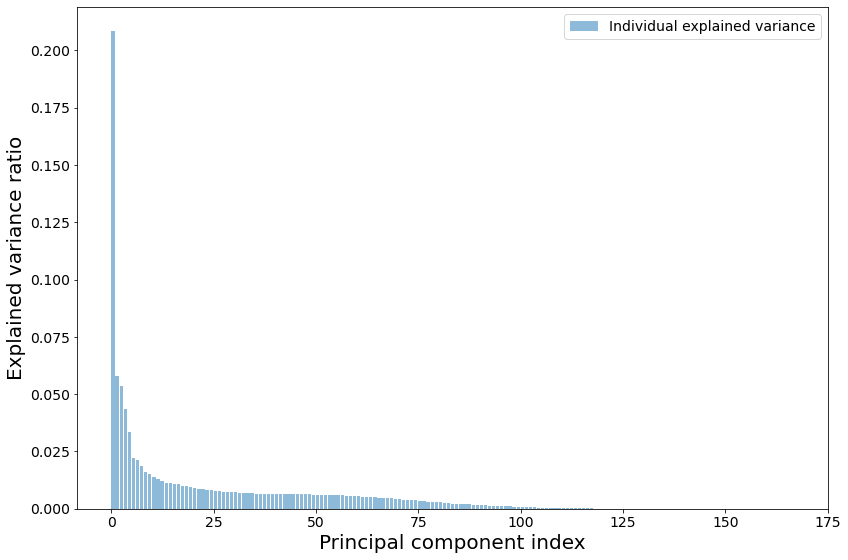

In [105]:
exp_var_rat_pca = pca.explained_variance_ratio_

plt.bar(np.arange(len(exp_var_rat_pca)), exp_var_rat_pca, alpha=0.5, align = 'edge', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

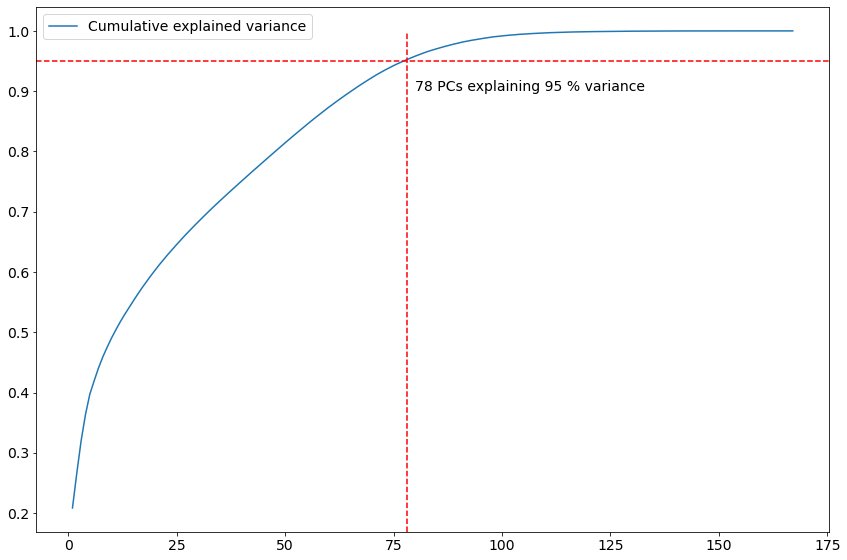

In [49]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained, label='Cumulative explained variance')
plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
plt.text(80, 0.9, f"{chosen_number} PCs explaining 95 % variance", clip_on=True)
plt.legend()
plt.tight_layout()

In [107]:
def shuffle_dataset(dataset):
    """
    Мешаем данные
    """
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для перемешанных данных
    """
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
        
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для реальных данных
    """
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    
    return pca.explained_variance_ratio_


# Дальше идет ряд графиков для визуализации

def plot_mean_and_ci(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_ci(ax, variance_by_chance, label="chance", color_mean="red", color_shading="red")


def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ratio", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

    
def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)


def calc_permutat_pval(real_values, permut_values, eps=None):
    """
    Сравниваем долю объясненной дисперсии для реальных данных и для перемешанных
    """
    eps = eps or (1 / (permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    """
    Главная функция, которая просто запускает все, что выше
    """
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

  0%|          | 0/20 [00:00<?, ?it/s]

0 iter


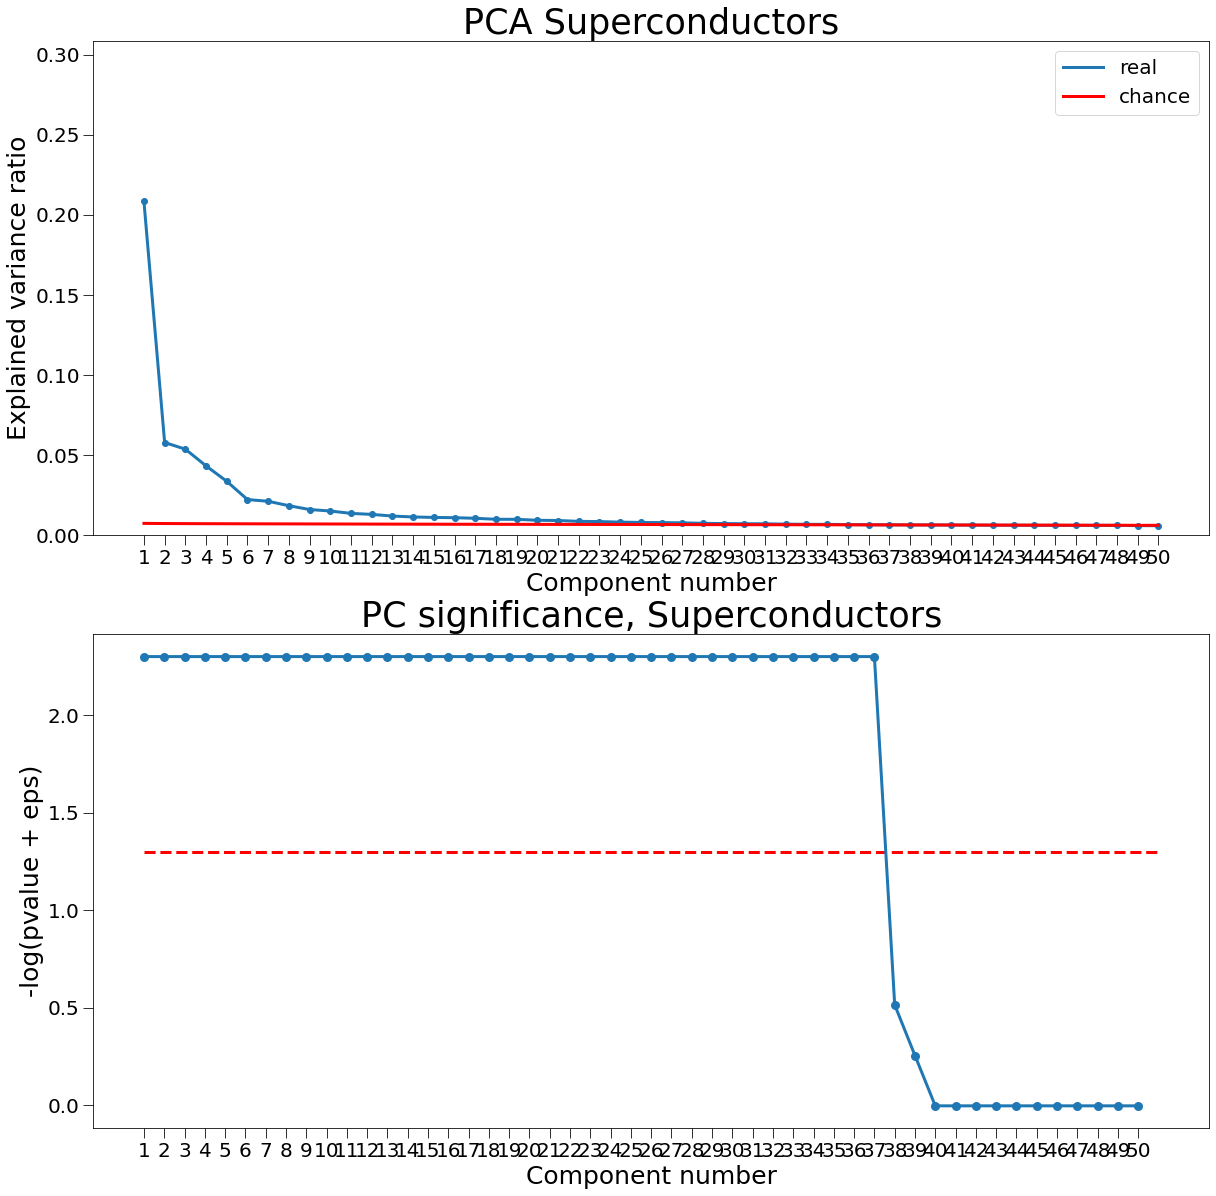

In [115]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, pd.DataFrame(stX_train), "Superconductors", n_replics=20, n_components=50)

Let's try it out with 78 principal components, as they explain 95 % of the variance:

In [37]:
pca_reduced = PCA(n_components=78, random_state=42).fit(stX_train)

In [38]:
X_train_reduced = pca_reduced.transform(stX_train)
X_test_reduced = pca_reduced.transform(stX_test)

In [39]:
lr_model = LinearRegression().fit(X_train_reduced, y_train)
y_pred_train = lr_model.predict(X_train_reduced)
y_pred_test = lr_model.predict(X_test_reduced)

statistics_train = lr_statistics(y_train, y_pred_train, stX_train)
statistics_test = lr_statistics(y_test, y_pred_test, stX_test)

lr_data_statistics = {
    "Training data": statistics_train,
    "Test data": statistics_test
}
lr_df = pd.DataFrame(lr_data_statistics, index=["Mean Absolute Error(MAE)",
                                "Mean Squared Error(MSE)",
                                "Root Mean Squared Error(RMSE)",
                                "Root Mean Squared Log Error(RMSLE)",
                                "$R^2$",
                                "Adjusted $R^2$"
                               ])

lr_df.style.set_caption("Statistics of Linear Regression model")

,Training data,Test data
Mean Absolute Error(MAE),14.625187,14.308774
Mean Squared Error(MSE),389.402485,363.175588
Root Mean Squared Error(RMSE),19.733284,19.057166
Root Mean Squared Log Error(RMSLE),4.442216,4.365451
$R^2$,0.669662,0.684492
Adjusted $R^2$,0.666387,0.671593


Let's try it out with 38 principal components, according to the shuffling of data:

In [112]:
pca_reduced = PCA(n_components=38, random_state=42).fit(stX_train)

In [113]:
X_train_reduced = pca_reduced.transform(stX_train)
X_test_reduced = pca_reduced.transform(stX_test)

In [114]:
lr_model = LinearRegression().fit(X_train_reduced, y_train)
y_pred_train = lr_model.predict(X_train_reduced)
y_pred_test = lr_model.predict(X_test_reduced)

statistics_train = lr_statistics(y_train, y_pred_train, stX_train)
statistics_test = lr_statistics(y_test, y_pred_test, stX_test)

lr_data_statistics = {
    "Training data": statistics_train,
    "Test data": statistics_test
}
lr_df = pd.DataFrame(lr_data_statistics, index=["Mean Absolute Error(MAE)",
                                "Mean Squared Error(MSE)",
                                "Root Mean Squared Error(RMSE)",
                                "Root Mean Squared Log Error(RMSLE)",
                                "$R^2$",
                                "Adjusted $R^2$"
                               ])

lr_df.style.set_caption("Statistics of Linear Regression model")

,Training data,Test data
Mean Absolute Error(MAE),15.675754,15.319918
Mean Squared Error(MSE),415.443002,387.383526
Root Mean Squared Error(RMSE),20.382419,19.682061
Root Mean Squared Log Error(RMSLE),4.514689,4.436447
$R^2$,0.647571,0.663461
Adjusted $R^2$,0.644077,0.649703


## Kernel PCA

In [18]:
from sklearn.decomposition import KernelPCA

In [41]:
kpca = KernelPCA(kernel = "rbf", n_components=stX_train.shape[1], random_state=42).fit(stX_train)

In [43]:
X_kpca_training_reduced = kpca.transform(stX_train)
X_kpca_test_reduced = kpca.transform(stX_test)

In [45]:
lr_model = LinearRegression().fit(X_kpca_training_reduced, y_train)
y_pred_train = lr_model.predict(X_kpca_training_reduced)
y_pred_test = lr_model.predict(X_kpca_test_reduced)

statistics_train = lr_statistics(y_train, y_pred_train, stX_train)
statistics_test = lr_statistics(y_test, y_pred_test, stX_test)

lr_data_statistics = {
    "Training data": statistics_train,
    "Test data": statistics_test
}
lr_df = pd.DataFrame(lr_data_statistics, index=["Mean Absolute Error(MAE)",
                                "Mean Squared Error(MSE)",
                                "Root Mean Squared Error(RMSE)",
                                "Root Mean Squared Log Error(RMSLE)",
                                "$R^2$",
                                "Adjusted $R^2$"
                               ])

lr_df.style.set_caption("Statistics of Linear Regression model")

,Training data,Test data
Mean Absolute Error(MAE),10.425693,10.286007
Mean Squared Error(MSE),234.393300,219.546192
Root Mean Squared Error(RMSE),15.309909,14.817091
Root Mean Squared Log Error(RMSLE),3.912788,3.849297
$R^2$,0.801159,0.809269
Adjusted $R^2$,0.799188,0.801472


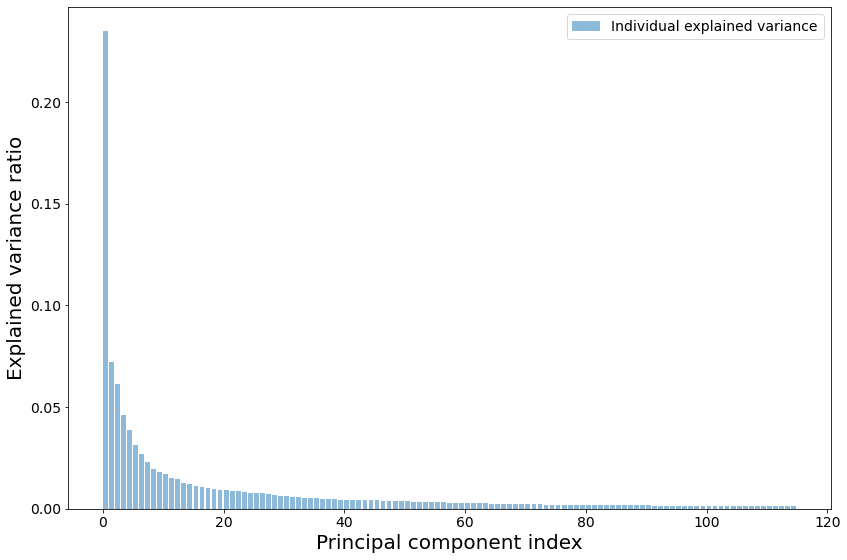

In [106]:
exp_var_kpca = np.var(X_kpca_training_reduced, axis=0)
exp_var_rat_kpca = exp_var_kpca / np.sum(exp_var_kpca)

plt.bar(np.arange(len(exp_var_rat_kpca)), exp_var_rat_kpca, alpha=0.5, align = 'edge', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

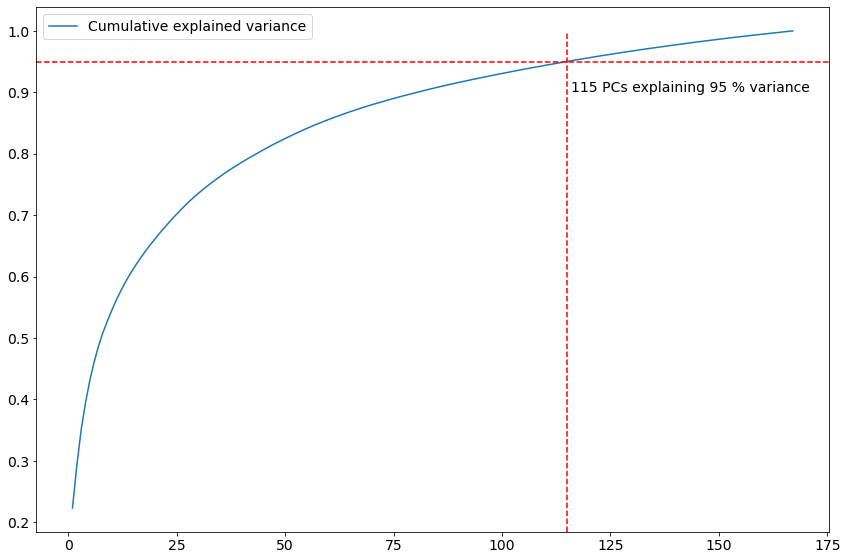

In [60]:
ths = 0.95
total_explained = np.cumsum(exp_var_rat_kpca)


plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained, label='Cumulative explained variance')
plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
plt.text(116, 0.9, f"{chosen_number} PCs explaining 95 % variance", clip_on=True)
plt.legend()
plt.tight_layout()

Trying it out with less PCs:

In [61]:
kpca = KernelPCA(kernel = "rbf", n_components=115, random_state=42).fit(stX_train)

In [62]:
X_kpca_training_reduced = kpca.transform(stX_train)
X_kpca_test_reduced = kpca.transform(stX_test)

In [63]:
lr_model = LinearRegression().fit(X_kpca_training_reduced, y_train)
y_pred_train = lr_model.predict(X_kpca_training_reduced)
y_pred_test = lr_model.predict(X_kpca_test_reduced)

statistics_train = lr_statistics(y_train, y_pred_train, stX_train)
statistics_test = lr_statistics(y_test, y_pred_test, stX_test)

lr_data_statistics = {
    "Training data": statistics_train,
    "Test data": statistics_test
}
lr_df = pd.DataFrame(lr_data_statistics, index=["Mean Absolute Error(MAE)",
                                "Mean Squared Error(MSE)",
                                "Root Mean Squared Error(RMSE)",
                                "Root Mean Squared Log Error(RMSLE)",
                                "$R^2$",
                                "Adjusted $R^2$"
                               ])

lr_df.style.set_caption("Statistics of Linear Regression model")

,Training data,Test data
Mean Absolute Error(MAE),10.844032,10.738928
Mean Squared Error(MSE),247.838705,233.403369
Root Mean Squared Error(RMSE),15.742894,15.277545
Root Mean Squared Log Error(RMSLE),3.967732,3.908650
$R^2$,0.789753,0.797231
Adjusted $R^2$,0.787669,0.788942


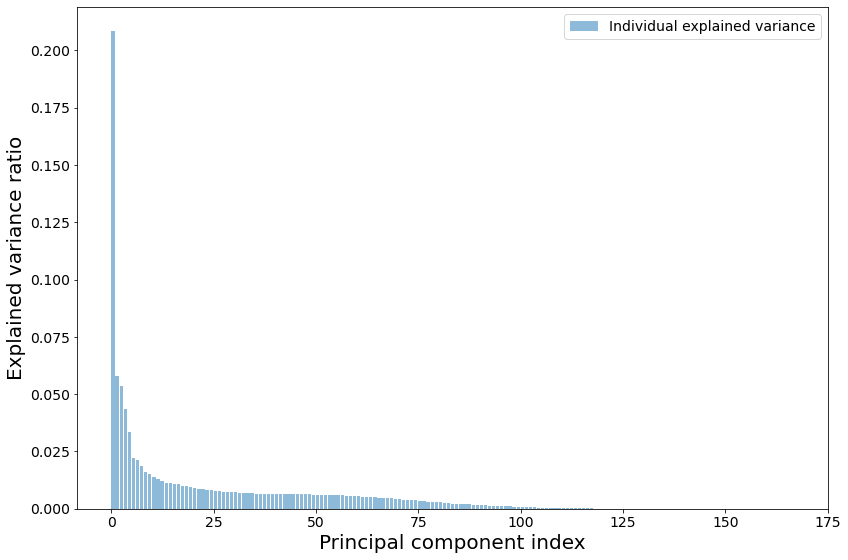

In [64]:
exp_var_kpca = np.var(X_kpca_training_reduced, axis=0)
exp_var_rat_kpca = exp_var_kpca / np.sum(exp_var_kpca)

plt.bar(np.arange(len(exp_var_rat_kpca)), exp_var_rat_kpca, alpha=0.5, align = 'edge', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

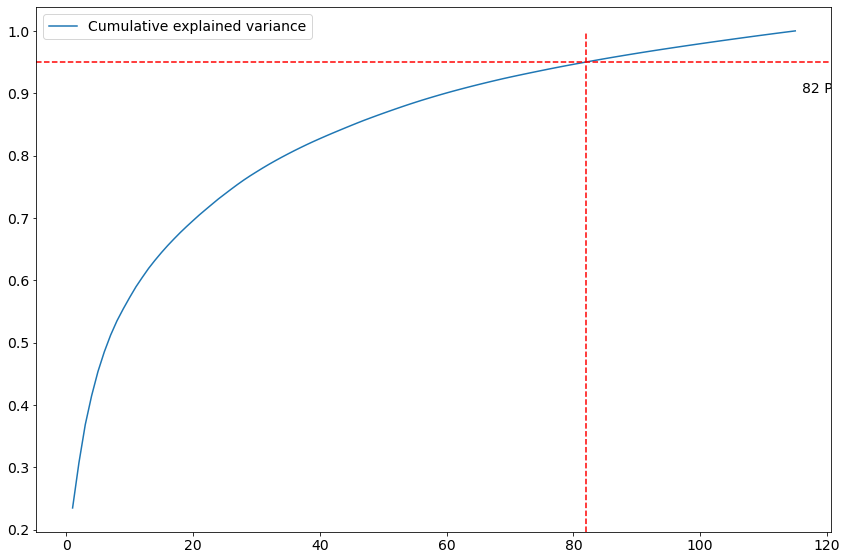

In [65]:
ths = 0.95
total_explained = np.cumsum(exp_var_rat_kpca)


plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained, label='Cumulative explained variance')
plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
plt.text(116, 0.9, f"{chosen_number} PCs explaining 95 % variance", clip_on=True)
plt.legend()
plt.tight_layout()

Conclusions: kernel PCAs significantly improved the quality! However, maybe PCA more than 115 could fit better, though the R squared didn't get that much less for kernel PCA.